<a href="https://colab.research.google.com/github/slvyarc/Text-Prediction-Model/blob/main/Predicting_the_next_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting the next word**
Dalam notebook ini, kita akan membuat model untuk memprediksi kata berikutnya dalam urutan teks menggunakan korpus soneta Shakespeare. Kita juga akan membuat beberapa fungsi bantu untuk memproses data.

Dataset yang akan kita gunakan adalah Soneta Shakespeare, yang berisi lebih dari 2000 baris teks dari soneta Shakespeare. [Link Dataset](https://www.opensourceshakespeare.org/views/sonnets/sonnet_view.php?range=viewrange&sonnetrange1=1&sonnetrange2=154)

Mari kita mulai!


## Mengimpor Library yang Diperlukan
Mari kita mulai dengan mengimpor library yang kita butuhkan untuk membangun model prediksi kata berikutnya.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU

### Mengunduh File dan Membaca Data

Di bagian ini, kita akan menggunakan modul gdown untuk mengunduh file teks soneta Shakespeare dari Google Drive. Setelah diunduh, kita akan membaca data dari file tersebut dan menyimpannya dalam variabel untuk digunakan selanjutnya.

In [2]:
!pip install gdown==5.1.0 #modul gdown digunakan untuk mengunduh dataset dari Google Drive

In [3]:
# mengunduh file Soneta Shakespeare dengan nama sonnets.txt dari Google Drive
!gdown --id 108jAePKK4R3BVYBbYJZ32JWUwxeMg20K

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=108jAePKK4R3BVYBbYJZ32JWUwxeMg20K
To: /content/sonnets.txt
100% 93.6k/93.6k [00:00<00:00, 82.3MB/s]


In [4]:
# Mendefinisikan path untuk file dengan soneta
SONNETS_FILE = './sonnets.txt'

# Membaca data dari file teks
with open('./sonnets.txt') as f:
    data = f.read()

# Mengonversi teks menjadi huruf kecil dan menyimpannya sebagai daftar
corpus = data.lower().split("\n")

# Mencetak jumlah baris soneta yang telah dibaca
print(f"Terdapat {len(corpus)} baris soneta\n")

# Menampilkan lima baris pertama soneta
print(f"Kelima baris pertama terlihat seperti ini:\n")
for i in range(5):
  print(corpus[i])


Terdapat 2159 baris soneta

Kelima baris pertama terlihat seperti ini:

from fairest creatures we desire increase,
that thereby beauty's rose might never die,
but as the riper should by time decease,
his tender heir might bear his memory:
but thou, contracted to thine own bright eyes,


## Tokenisasi Teks

Tokenisasi adalah proses mengubah teks menjadi urutan kata atau token. Kita akan menggunakan tokenizer untuk memproses korpus (sekumpulan teks) dan menyimpan total jumlah kata yang unik.


In [5]:
# Membuat objek Tokenizer
tokenizer = Tokenizer()
# Memasangkan Tokenizer pada korpus teks
tokenizer.fit_on_texts(corpus)
# Menghitung total jumlah kata dalam korpus teks, ditambah 1 untuk memperhitungkan padding
total_words = len(tokenizer.word_index) + 1


Saat mengonversi teks menjadi urutan kata, kita dapat menggunakan metode texts_to_sequences. Namun, dalam fungsi yang akan dievaluasi selanjutnya, kita perlu memproses korpus ini satu baris pada satu waktu. Oleh karena itu, penting untuk diingat bahwa cara kita memberikan data akan memengaruhi hasilnya.

In [6]:
# Mengonversi teks menjadi urutan kata-kata
corpus[0]

'from fairest creatures we desire increase,'

Jika kita langsung memasukkan teks ini ke dalam metode texts_to_sequences, kita akan mendapatkan hasil yang tidak terduga:

In [7]:
tokenizer.texts_to_sequences(corpus[0])

[[],
 [],
 [58],
 [],
 [],
 [],
 [17],
 [6],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [6],
 [],
 [],
 [],
 [],
 [17],
 [],
 [],
 []]

Hal ini terjadi karena texts_to_sequences mengharapkan sebuah daftar (list) dan kita memberikan sebuah string. Namun, string juga merupakan iterable di Python sehingga kita akan mendapatkan indeks kata dari setiap karakter dalam string tersebut.

Sebaliknya, kita perlu memasukkan contoh ini ke dalam daftar sebelum meneruskannya ke metode:

In [8]:
tokenizer.texts_to_sequences([corpus[0]])

[[34, 417, 877, 166, 213, 517]]

Perhatikan bahwa hasil yang kita terima adalah urutan kata yang berada di dalam sebuah daftar. Jadi, untuk mendapatkan urutan kata yang kita inginkan saja, kita perlu mengambil item pertama dari daftar tersebut. Caranya adalah seperti ini:

In [9]:
tokenizer.texts_to_sequences([corpus[0]])[0]

[34, 417, 877, 166, 213, 517]

## Membuat n-gram

Fungsi ini menerima korpus teks dan objek tokenizer yang sudah dipasangkan dengan kata-kata dalam korpus. Ini menghasilkan daftar urutan n-gram untuk setiap baris teks dalam korpus.

In [10]:
def n_gram_seqs(corpus, tokenizer):
    """
    Menghasilkan daftar urutan n-gram

    Args:
        corpus (list of string): baris teks untuk menghasilkan n-gram
        tokenizer (objek): sebuah instance dari kelas Tokenizer yang berisi kamus kata-indeks

    Returns:
        input_sequences (list of int): urutan n-gram untuk setiap baris dalam korpus
    """
    input_sequences = []

    # Iterasi melalui setiap baris dalam korpus
    for line in corpus:
        # Menerjemahkan baris menjadi daftar token
        token_list = tokenizer.texts_to_sequences([line])[0]

        # Membuat n-gram sequence untuk setiap panjang n
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]

            # Menambahkan urutan n-gram ke daftar input_sequences
            input_sequences.append(n_gram_sequence)

    return input_sequences

Selanjutnya, kita ingin menguji fungsi `n_gram_seqs` dengan satu contoh. Hasilnya akan menjadi daftar urutan n-gram untuk contoh pertama dalam korpus.

In [11]:
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("Urutan n-gram untuk contoh pertama terlihat seperti ini:\n")
first_example_sequence

Urutan n-gram untuk contoh pertama terlihat seperti ini:



[[34, 417],
 [34, 417, 877],
 [34, 417, 877, 166],
 [34, 417, 877, 166, 213],
 [34, 417, 877, 166, 213, 517]]

In [12]:
# Uji fungsi dengan korpus yang lebih besar
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("Urutan n-gram untuk 3 contoh berikutnya terlihat seperti ini:\n:\n")
next_3_examples_sequence

Urutan n-gram untuk 3 contoh berikutnya terlihat seperti ini:
:



[[8, 878],
 [8, 878, 134],
 [8, 878, 134, 351],
 [8, 878, 134, 351, 102],
 [8, 878, 134, 351, 102, 156],
 [8, 878, 134, 351, 102, 156, 199],
 [16, 22],
 [16, 22, 2],
 [16, 22, 2, 879],
 [16, 22, 2, 879, 61],
 [16, 22, 2, 879, 61, 30],
 [16, 22, 2, 879, 61, 30, 48],
 [16, 22, 2, 879, 61, 30, 48, 634],
 [25, 311],
 [25, 311, 635],
 [25, 311, 635, 102],
 [25, 311, 635, 102, 200],
 [25, 311, 635, 102, 200, 25],
 [25, 311, 635, 102, 200, 25, 278]]

Terapkan transformasi `n_gram_seqs` ke seluruh korpus dan simpan panjang urutan maksimum untuk digunakan nanti.

In [13]:
# Terapkan transformasi n_gram_seqs ke seluruh korpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Simpan panjang maksimum
max_sequence_len = max([len(x) for x in input_sequences])

print(f"Urutan n-gram dari input_sequences memiliki panjang: {len(input_sequences)}")
print(f"Panjang maksimum urutan adalah: {max_sequence_len}")

Urutan n-gram dari input_sequences memiliki panjang: 15462
Panjang maksimum urutan adalah: 11


## Menambahkan Padding pada Urutan

Sekarang membuat fungsi `pad_seqs` yang akan menambahkan padding pada setiap urutan yang diberikan hingga mencapai panjang maksimum yang diinginkan. Perhatikan bahwa fungsi ini menerima sebuah daftar urutan dan seharusnya mengembalikan sebuah array numpy dengan urutan yang telah dipad.

In [14]:
def pad_seqs(input_sequences, maxlen):
    """
    Menambahkan padding pada urutan yang diberikan ke panjang maksimum yang diinginkan.

    Args:
        input_sequences (list of int): Urutan yang akan dipad
        maxlen (int): Panjang maksimum yang diinginkan untuk setiap urutan

    Returns:
        padded_sequences (numpy array of int): Urutan yang telah dipad
    """
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences

In [15]:
# Menggunakan fungsi pad_seqs untuk melakukan padding pada urutan n-gram pertama
# dengan panjang maksimum yang ditemukan dari urutan n-gram tersebut.
first_padded_seq = pad_seqs(first_example_sequence, max([len(x) for x in first_example_sequence]))

# Menampilkan hasil urutan n-gram yang telah dipad
first_padded_seq


array([[  0,   0,   0,   0,  34, 417],
       [  0,   0,   0,  34, 417, 877],
       [  0,   0,  34, 417, 877, 166],
       [  0,  34, 417, 877, 166, 213],
       [ 34, 417, 877, 166, 213, 517]], dtype=int32)

In [16]:
# Uji fungsi dengan urutan n-gram dari 3 contoh berikutnya
next_3_padded_seq = pad_seqs(next_3_examples_sequence, max([len(s) for s in next_3_examples_sequence]))
next_3_padded_seq

array([[  0,   0,   0,   0,   0,   0,   8, 878],
       [  0,   0,   0,   0,   0,   8, 878, 134],
       [  0,   0,   0,   0,   8, 878, 134, 351],
       [  0,   0,   0,   8, 878, 134, 351, 102],
       [  0,   0,   8, 878, 134, 351, 102, 156],
       [  0,   8, 878, 134, 351, 102, 156, 199],
       [  0,   0,   0,   0,   0,   0,  16,  22],
       [  0,   0,   0,   0,   0,  16,  22,   2],
       [  0,   0,   0,   0,  16,  22,   2, 879],
       [  0,   0,   0,  16,  22,   2, 879,  61],
       [  0,   0,  16,  22,   2, 879,  61,  30],
       [  0,  16,  22,   2, 879,  61,  30,  48],
       [ 16,  22,   2, 879,  61,  30,  48, 634],
       [  0,   0,   0,   0,   0,   0,  25, 311],
       [  0,   0,   0,   0,   0,  25, 311, 635],
       [  0,   0,   0,   0,  25, 311, 635, 102],
       [  0,   0,   0,  25, 311, 635, 102, 200],
       [  0,   0,  25, 311, 635, 102, 200,  25],
       [  0,  25, 311, 635, 102, 200,  25, 278]], dtype=int32)

In [17]:
# Melakukan padding pada seluruh korpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"Korpus yang telah dipad memiliki bentuk: {input_sequences.shape}")


Korpus yang telah dipad memiliki bentuk: (15462, 11)


## Memisahkan data menjadi fitur dan label

Sebelum data dimasukkan ke dalam jaringan saraf, kita perlu memisahkannya menjadi fitur dan label. Fitur dalam hal ini akan menjadi urutan n-gram yang telah dipad dengan kata terakhir dihapus, sementara labelnya akan menjadi kata yang dihapus.

Fungsi ini mengharapkan urutan n-gram yang telah dipad sebagai input dan harus mengembalikan tuple yang berisi fitur dan label yang dienkoding dalam bentuk one-hot.

Perhatikan bahwa fungsi ini juga menerima total kata dalam korpus. Parameter ini akan sangat penting saat menerapkan enkoding one-hot pada label karena setiap kata dalam korpus akan menjadi label setidaknya sekali.

In [18]:
def features_and_labels(input_sequences, total_words):
    """
    Menghasilkan fitur dan label dari n-gram

    Args:
        input_sequences (list of int): urutan untuk memisahkan fitur dan label
        total_words (int): ukuran kosakata

    Returns:
        features, one_hot_labels (array of int, array of int): array fitur dan label yang dienkoding dalam bentuk one-hot
    """
    features = input_sequences[:,:-1]  # Mengambil semua kata kecuali yang terakhir untuk fitur
    labels = input_sequences[:,-1]     # Mengambil kata terakhir sebagai label
    one_hot_labels = to_categorical(labels, num_classes=total_words)  # Mengkonversi label menjadi one-hot encoding

    return features, one_hot_labels

In [19]:
# Uji fungsi dengan urutan n-gram yang telah dipad dari contoh pertama
first_features, first_labels = features_and_labels(first_padded_seq, total_words)

print(f"labels memiliki bentuk: {first_labels.shape}")
print("\nfitur terlihat seperti ini:\n")
first_features


labels memiliki bentuk: (5, 3211)

fitur terlihat seperti ini:



array([[  0,   0,   0,   0,  34],
       [  0,   0,   0,  34, 417],
       [  0,   0,  34, 417, 877],
       [  0,  34, 417, 877, 166],
       [ 34, 417, 877, 166, 213]], dtype=int32)

In [20]:
# Bagi seluruh korpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"fitur memiliki bentuk: {features.shape}")
print(f"label memiliki bentuk: {labels.shape}")


fitur memiliki bentuk: (15462, 10)
label memiliki bentuk: (15462, 3211)


## Membuat model

Kita perlu membuat model dengan arsitektur sebagai berikut:

1. Layer Embedding dengan output_dim=100.
2. Layer LSTM Bidirectional.
3. Layer Dense dengan jumlah unit yang sama dengan total jumlah kata dalam korpus dan menggunakan fungsi aktivasi softmax.

tingkat akurasi setidaknya 80%.

In [23]:
import tensorflow as tf

def create_model(total_words, max_sequence_len):
    """
    Membuat model generator teks

    Args:
        total_words (int): ukuran kosakata untuk input layer Embedding
        max_sequence_len (int): panjang urutan input

    Returns:
        model (tf.keras Model): model generator teks
    """
    model = Sequential()

    # Layer Embedding
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))

    # Layer GRU Bidirectional
    model.add(Bidirectional(GRU(64)))

    # Layer Dense
    model.add(Dense(total_words, activation='softmax'))

    # Kompilasi model
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model


In [24]:
# Dapatkan model yang belum dilatih
model = create_model(total_words, max_sequence_len)

# Latih model
history = model.fit(features, labels, epochs=50, verbose=1)


Epoch 1/50
484/484 [==============================] - 18s 24ms/step - loss: 6.9173 - accuracy: 0.0228
Epoch 2/50
484/484 [==============================] - 4s 8ms/step - loss: 6.4006 - accuracy: 0.0364
Epoch 3/50
484/484 [==============================] - 4s 8ms/step - loss: 6.1048 - accuracy: 0.0501
Epoch 4/50
484/484 [==============================] - 4s 9ms/step - loss: 5.8023 - accuracy: 0.0675
Epoch 5/50
484/484 [==============================] - 4s 8ms/step - loss: 5.5094 - accuracy: 0.0821
Epoch 6/50
484/484 [==============================] - 4s 8ms/step - loss: 5.2185 - accuracy: 0.0979
Epoch 7/50
484/484 [==============================] - 4s 9ms/step - loss: 4.9301 - accuracy: 0.1133
Epoch 8/50
484/484 [==============================] - 4s 7ms/step - loss: 4.6353 - accuracy: 0.1387
Epoch 9/50
484/484 [==============================] - 4s 7ms/step - loss: 4.3363 - accuracy: 0.1747
Epoch 10/50
484/484 [==============================] - 5s 9ms/step - loss: 4.0433 - accuracy: 0.21

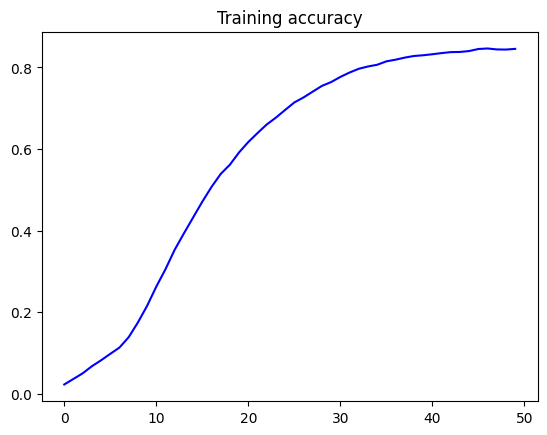

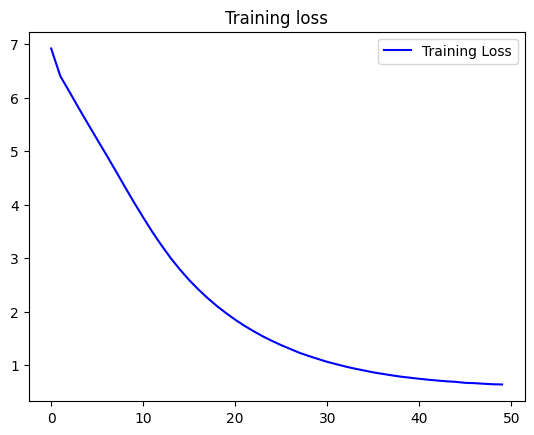

In [25]:
# Lihat kurva pelatihan model

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

mengunduh file history.pkl yang berisi informasi history model

In [26]:
def download_history():
    import pickle
    from google.colab import files

    # Simpan history pelatihan ke file history.pkl
    with open('history.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    # Unduh file history.pkl
    files.download('history.pkl')

download_history()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Uji Model
Setelah semua pekerjaan, saatnya melihat model menghasilkan teks.

In [27]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100

for _ in range(next_words):
    # Konversi teks menjadi urutan
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    # Pad urutan
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    # Dapatkan probabilitas untuk memprediksi kata
    predicted = model.predict(token_list, verbose=0)
    # Pilih kata berikutnya berdasarkan probabilitas maksimum
    predicted = np.argmax(predicted, axis=-1).item()
    # Dapatkan kata aktual dari indeks kata
    output_word = tokenizer.index_word[predicted]
    # Tambahkan ke teks saat ini
    seed_text += " " + output_word

print(seed_text)

Help me Obi Wan Kenobi, you're my only hope please thee control me control minds to cross twain oppress'd luck light ' have forgot old heard woe near less hour ' new ' show them without thy granting grow sky ' cross ' new wrong shows brought and died ' woe and thine rare more more must go ill well of thee untrue still ' have grow express'd of nought delight mad worn blest we doth view asleep forgot ' friend well knows of kings and kings oppress'd luck compile compile torn fashion force be so near slain ' have express'd form ' show of thee sight would go
